**Background:**
We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.
Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

**Data Description:**
You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

# Table of contents
- [Verify GPU](#gpu)
- [Data Cleaning & EDA](#eda)
- [Data splitting](#pipe)
- [Modelling](#md)
    - [Moving Average](#ti)
    - [ARIMA](#arima)
    - [PROPHET by Facebook](#fb)
    - [LSTM](#lstm)
- [Conclusion](#con)

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(123)

# Verify GPU <a class="anchor" id="gpu"></a>

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# GPU of my machine that is visible to TensorFlow
print('GPU name:',tf.test.gpu_device_name())

Num GPUs Available:  1
GPU name: /device:GPU:0


2023-12-16 06:24:38.441562: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-16 06:24:38.441600: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-16 06:24:38.441612: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-16 06:24:38.442084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 06:24:38.442493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Read all sheets in the Excel file
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'
df = pd.read_excel(file_name, sheet_name=None)

# df will be a dictionary, where the keys are the sheet names and the values are the corresponding dataframes
for i in df.keys():
    print(i)

Russia - Sberbank Rossii PAO (S
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (M
Brazil - Minerva SABrazil (BEEF
Argentina - Pampa Energia SA (P
Colombia - Cementos Argos SA (C
South Africa - Impala Platinum 
South Korea - Dongkuk Steel Mil


There are 8 companies that we can work on, and I choose to work on the company in Russia.

In [5]:
# read the dataframe
russia = pd.read_excel(file_name, sheet_name='Russia - Sberbank Rossii PAO (S')

## Data Cleaning & EDA <a class="anchor" id="eda"></a>

In [6]:
print(f'The Russian company dataframe has {russia.shape[0]} rows and {russia.shape[1]} columns.')

The Russian company dataframe has 312 rows and 7 columns.


In [7]:
russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [8]:
russia.tail()

,Date,Price,Open,High,Low,Vol.,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [9]:
russia.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    1
dtype: int64

We see that the last row accounts for one NaN value in columns `Vol.` and `Change %`.

In [10]:
# remove the last row
russia=russia.iloc[:-1]
russia.tail()

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010


In [11]:
# sanity check
russia.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [12]:
# check data type
russia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      311 non-null    object 
 1   Price     311 non-null    object 
 2   Open      311 non-null    object 
 3   High      311 non-null    object 
 4   Low       311 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.1+ KB


We'll only use 2 columns `Date` and `Price`, so let's convert their data type properly.

In [13]:
# change to datetime type
russia["Date"] = pd.to_datetime(russia["Date"])
# change to float
russia['Price'] = russia['Price'].astype(float)

# set Date as index
russia = russia.set_index("Date")

russia.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294,294.42,290.26,47.00M,-0.0076
2021-03-30,293.25,294.86,295.72,291.5,38.81M,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159
2021-03-25,286.66,286.5,287.03,283.85,35.22M,0.0030


In [14]:
# sanity check
russia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    object 
 2   High      311 non-null    object 
 3   Low       311 non-null    object 
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(2), object(4)
memory usage: 17.0+ KB


In [15]:
# check duplicate values
russia.duplicated().sum()

0

In [16]:
first_day=russia.index.min()
last_day=russia.index.max()

first_day, last_day

(Timestamp('2020-01-03 00:00:00'), Timestamp('2021-03-31 00:00:00'))

The dataframe starts in 2020 Jan and ends in 2021 Mar.

### Missing values and dates
We will check if there are any dates missing from our index. We can construct the full date range between our first and last observation date and see the difference with our index.

In [17]:
#look at the actual number of dates that exist for this time period
full_range = pd.date_range(start=first_day, end=last_day, freq="D")

#look at and compares the actual number of dates in a calendar to the number of dates in our dataset
missing_date=full_range.difference(russia.index)
missing_date

DatetimeIndex(['2020-01-04', '2020-01-05', '2020-01-07', '2020-01-11',
               '2020-01-12', '2020-01-18', '2020-01-19', '2020-01-25',
               '2020-01-26', '2020-02-01',
               ...
               '2021-02-28', '2021-03-06', '2021-03-07', '2021-03-08',
               '2021-03-13', '2021-03-14', '2021-03-20', '2021-03-21',
               '2021-03-27', '2021-03-28'],
              dtype='datetime64[ns]', length=143, freq=None)

We miss price values for 143 days from 2020 Jan to 2021 Mar.

In [18]:
import holidays

ru_holidays=holidays.country_holidays('RU',language='en_US')
print(ru_holidays)

{'country': RU, 'expand': True, 'language': en_us, 'market': None, 'observed': True, 'subdiv': None, 'years': set()}


In [19]:
# look at what days are missing
missing_date_df=pd.DataFrame({'missing_date':missing_date})
for index,value in missing_date_df['missing_date'].items():
    if value in ru_holidays:
        missing_date_df.loc[index,'Day name']=ru_holidays.get(value) 
    else:
        missing_date_df.loc[index,'Day name']=value.day_name()

missing_date_df

,missing_date,Day name
0,2020-01-04,New Year Holidays
1,2020-01-05,New Year Holidays
2,2020-01-07,Christmas Day
3,2020-01-11,Saturday
4,2020-01-12,Sunday
...,...,...
138,2021-03-14,Sunday
139,2021-03-20,Saturday
140,2021-03-21,Sunday
141,2021-03-27,Saturday


In [20]:
missing_date_df['Day name'].value_counts()

Day name
Saturday                       61
Sunday                         61
New Year Holidays               5
Monday                          3
Christmas Day                   2
Fatherland Defender's Day       2
International Women's Day       2
Wednesday                       2
Holiday of Spring and Labor     1
Victory Day                     1
Russia Day                      1
Unity Day                       1
Thursday                        1
Name: count, dtype: int64

Sure enough, the missing days are mostly the days when the market closed or holidays. Let's see how the gaps present.

In [21]:
# russia with full day range
russia_clean = russia.reindex(full_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


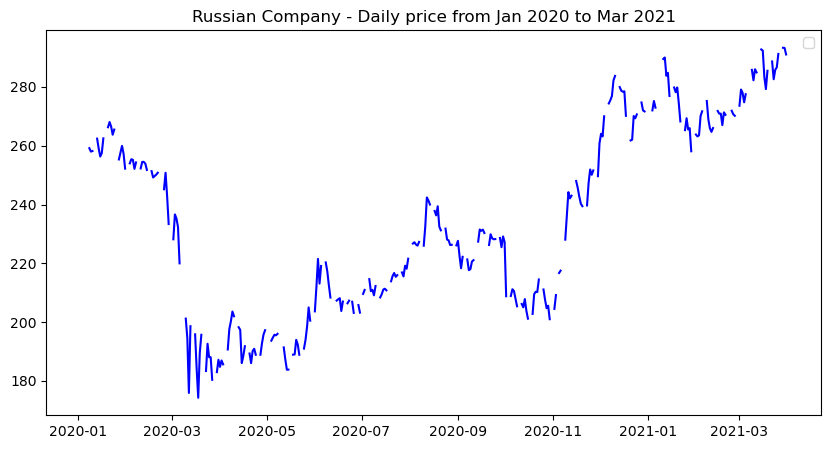

In [22]:
plt.figure(figsize=(10,5))
plt.plot(russia_clean.index, russia_clean["Price"], color='blue')
plt.title('Russian Company - Daily price from Jan 2020 to Mar 2021')
plt.legend(loc='best')
plt.show()

Now we'll set up the datasets for training, testing and predicting. 

Training set will be Q1, Q2, and Q3 2020, testing set is Q4 2020, and predicting set is 2021.
As their names suggest, training set will be used for the purpose of training, testing set is for fine tuning the model, predicting set is for evaluating the performance between models. 

In [23]:
russia_train=russia.loc[russia.index < "2020-10-01", ["Price"]]
russia_test=russia.loc[(russia.index > "2020-09-30") & (russia.index < "2021-01-01"),['Price']]
russia_predict=russia.loc[russia.index > "2020-12-31", ["Price"]]

In [24]:
# sanity check
print('Training indices:',russia_train.index.min(), russia_train.index.max())
print('Testing indices:',russia_test.index.min(), russia_test.index.max())
print('Predicting indices:',russia_predict.index.min(), russia_predict.index.max())

Training indices: 2020-01-03 00:00:00 2020-09-30 00:00:00
Testing indices: 2020-10-01 00:00:00 2020-12-30 00:00:00
Predicting indices: 2021-01-04 00:00:00 2021-03-31 00:00:00


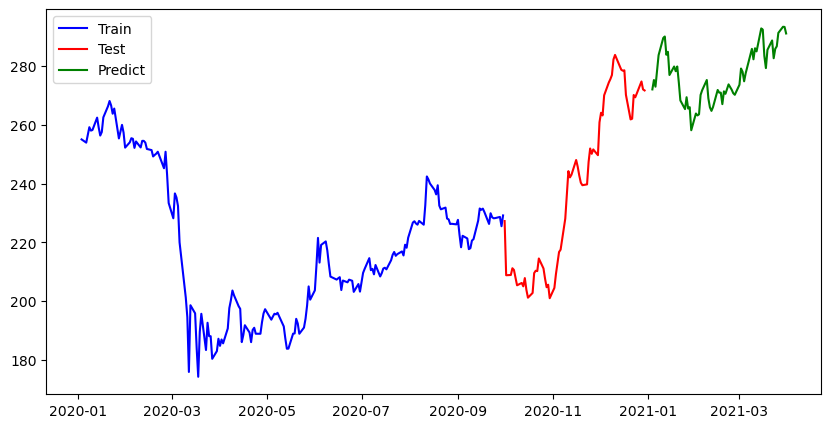

In [25]:
plt.figure(figsize=(10,5))
plt.plot(russia_train.index, russia_train['Price'], color='blue', label='Train')
plt.plot(russia_test.index, russia_test['Price'], color='red', label='Test')
plt.plot(russia_predict.index, russia_predict['Price'], color='green', label="Predict")
plt.legend(loc='best')
plt.show()

# Data Splitting <a class="anchor" id="pipe"></a>

Look at the dataframes again.

In [26]:
russia_train

,Price
Date,
2020-09-30,229.14
2020-09-29,225.48
2020-09-28,228.63
2020-09-25,228.24
2020-09-24,228.17
...,...
2020-01-10,258.19
2020-01-09,257.99
2020-01-08,259.15


The indices are not in ascending order. Let's fix them.

In [27]:
# sort index
russia_train.sort_index(ascending=True, inplace=True)
russia_test.sort_index(ascending=True, inplace=True)
russia_predict.sort_index(ascending=True, inplace=True)

In [28]:
# sanity check
russia_train

,Price
Date,
2020-01-03,255.00
2020-01-06,253.90
2020-01-08,259.15
2020-01-09,257.99
2020-01-10,258.19
...,...
2020-09-24,228.17
2020-09-25,228.24
2020-09-28,228.63


# Modelling <a class="anchor" id="md"></a>

## Moving Average <a class="anchor" id="ti"></a>

We'll use the average of the last *window-size* prices to create the predicted price in the test set, ie. for 5-day moving average `MA5`, the first day on the test set will equal the average of the last **5-day** prices in the train set. And we'll tune the window size for MA, whether 5, 10 or 21 days will best predict this dataset.

In [29]:
ti_test=pd.concat([russia_train.tail(21), russia_test])
ti_test=ti_test.reset_index() # reset index for the sake of self sanity-check

ti_test['MA5']=0
ti_test['MA10']=0
ti_test['MA21']=0

ti_test['MA5'][:21]=ti_test['Price'][:21] 
ti_test['MA10'][:21]=ti_test['Price'][:21]
ti_test['MA21'][:21]=ti_test['Price'][:21]

for i in range (21,len(ti_test)):
    ti_test['MA5'][i]=np.mean(ti_test['MA5'][i-5:i]) # price on Oct 1 is the average of the last 5 prices in Sep
    ti_test['MA10'][i]=np.mean(ti_test['MA10'][i-10:i])
    ti_test['MA21'][i]=np.mean(ti_test['MA21'][i-21:i])

ti_test.head(30)

,Date,Price,MA5,MA10,MA21
0,2020-09-02,222.57,222.570000,222.570000,222.570000
1,2020-09-03,218.32,218.320000,218.320000,218.320000
2,2020-09-04,222.21,222.210000,222.210000,222.210000
3,2020-09-07,221.32,221.320000,221.320000,221.320000
4,2020-09-08,217.68,217.680000,217.680000,217.680000
5,2020-09-09,218.00,218.000000,218.000000,218.000000
6,2020-09-10,220.60,220.600000,220.600000,220.600000
7,2020-09-11,221.07,221.070000,221.070000,221.070000
8,2020-09-14,227.37,227.370000,227.370000,227.370000
9,2020-09-15,231.50,231.500000,231.500000,231.500000


MAPE 5-day MA: 0.1092882554535193
MAPE 10-day MA: 0.10924506227244174
MAPE 21-day MA: 0.10932010411790596


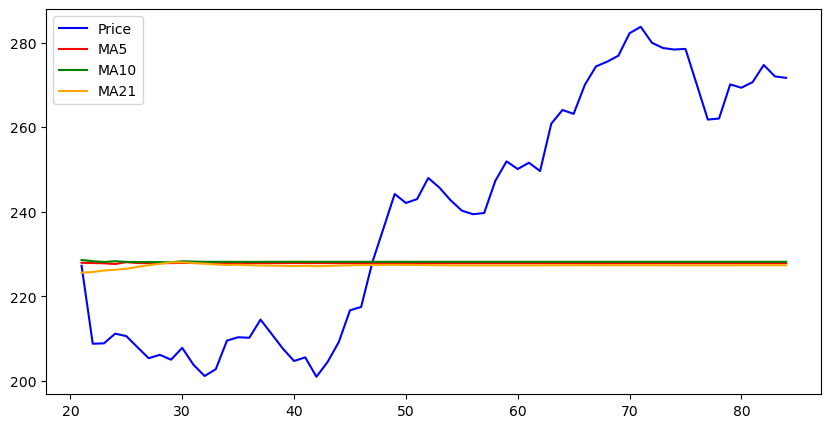

In [30]:
# get the values from October only
ti_test_oct=ti_test[21:]

y_true_ma=np.array(ti_test_oct['Price'])
y_pred_5ma=np.array(ti_test_oct['MA5'])
y_pred_10ma=np.array(ti_test_oct['MA10'])
y_pred_21ma=np.array(ti_test_oct['MA21'])
print('MAPE 5-day MA:',mean_absolute_percentage_error(y_true_ma, y_pred_5ma))
print('MAPE 10-day MA:',mean_absolute_percentage_error(y_true_ma, y_pred_10ma))
print('MAPE 21-day MA:',mean_absolute_percentage_error(y_true_ma, y_pred_21ma))

plt.figure(figsize=(10,5))
plt.plot(ti_test_oct['Price'], color='blue',label='Price')
plt.plot(ti_test_oct['MA5'], color='red', label='MA5')
plt.plot(ti_test_oct['MA10'], color='green', label='MA10')
plt.plot(ti_test_oct['MA21'], color='orange', label='MA21')
plt.legend(loc='best')
plt.show()

Sure enough, MA is a straight line since we use predicted prices to predict the next ones.

# ARIMA <a class="anchor" id="arima"></a>

In [31]:
from pmdarima.arima import auto_arima

In [32]:
# we'll use both train and test sets for training
arima_train=pd.concat([russia_train, russia_test])
arima = auto_arima(arima_train,
                    trace=True,
                    error_action="ignore",
                    suppress_warnings=True,
                    random_state=111,
                    stepwise=False,
                    seasonal=False)

arima.fit(arima_train)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1499.638, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1501.180, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1502.675, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1504.674, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1498.791, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1500.777, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1501.228, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1502.372, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1504.675, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1505.818, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1500.782, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1502.533, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1504.526, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1498.601, Time=0.32 sec
 ARIMA(3,1,0)(0

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [33]:
# predict on the 2021 dataset
forecast = arima.predict(len(russia_predict))
arima_pred=russia_predict.copy()
arima_pred["ARIMA Prediction"]=forecast.values
arima_pred.head()

/Users/thao/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Price,ARIMA Prediction
Date,,
2021-01-04,272.00,272.015073
2021-01-05,275.20,273.077896
2021-01-06,272.93,271.712241
2021-01-08,283.64,272.763563
2021-01-11,289.49,272.654947


MAPE by ARIMA: 0.026722166743258315


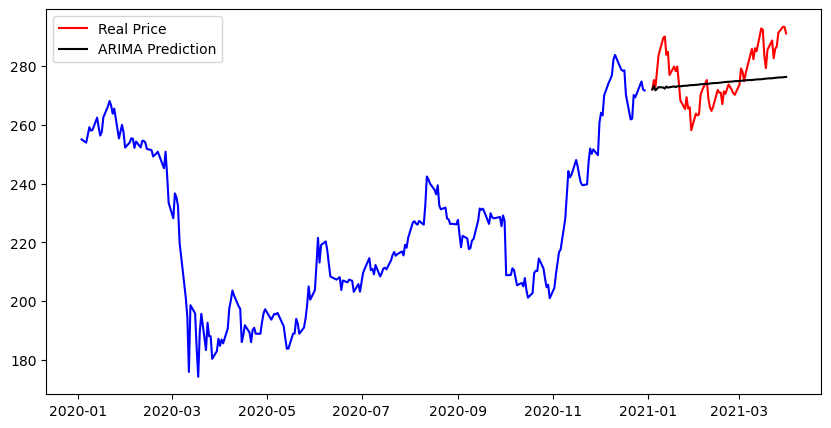

In [34]:
print('MAPE by ARIMA:',mean_absolute_percentage_error(arima_pred['Price'],arima_pred['ARIMA Prediction']))

#plot the predictions
plt.figure(figsize=(10,5))
plt.plot(arima_train.index, arima_train['Price'], color='blue')
plt.plot(arima_pred.index, arima_pred['Price'], color='red', label="Real Price")
plt.plot(arima_pred.index, arima_pred['ARIMA Prediction'], color='black', label="ARIMA Prediction")
plt.legend(loc='best')
plt.show()

An auto-ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. As it's evident from the plot, the model has captured an upward trend in the series, but does not focus on the seasonal part.

# PROPHET by Facebook <a class="anchor" id="fb"></a>

In [35]:
from prophet import Prophet

In [36]:
# same as ARIMA, we'll use both train and test sets for training
prophet_train=pd.concat([russia_train, russia_test]).reset_index()
prophet_train=prophet_train.rename(columns={"Date": "ds", "Price": "y"})
prophet_train.head()

,ds,y
0,2020-01-03,255.00
1,2020-01-06,253.90
2,2020-01-08,259.15
3,2020-01-09,257.99
4,2020-01-10,258.19


In [37]:
model = Prophet(daily_seasonality=True)
model.fit(prophet_train)

06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
# predict on the 2021 dataset
future = model.make_future_dataframe(periods=len(russia_predict), freq="d", include_history=False)
forecast = model.predict(future)
forecast['ds']=russia_predict.index
forecast['Price']=russia_predict.values
forecast.set_index('ds', inplace=True)
forecast[['Price','yhat']] #yhat is the prices predicted by PROPHET

,Price,yhat
ds,,
2021-01-04,272.00,280.958296
2021-01-05,275.20,281.034495
2021-01-06,272.93,279.650796
2021-01-08,283.64,280.546964
2021-01-11,289.49,283.399632
...,...,...
2021-03-25,286.66,331.143712
2021-03-26,291.22,331.219911
2021-03-29,293.30,329.836212


MAPE by PROPHET: 0.11062651165489262


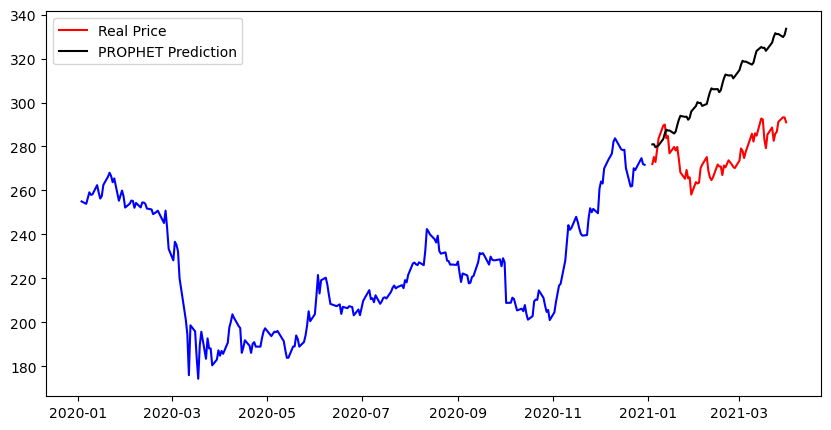

In [39]:
print('MAPE by PROPHET:',mean_absolute_percentage_error(forecast['Price'],forecast['yhat']))

#plot the predictions
plt.figure(figsize=(10,5))
plt.plot(prophet_train['ds'], prophet_train['y'], color='blue')
plt.plot(forecast.index, forecast['Price'], color='red', label="Real Price")
plt.plot(forecast.index, forecast['yhat'], color='black', label="PROPHET Prediction")
plt.legend(loc='best')
plt.show()

Same as ARIMA, PROPHET catches the upward trend, but not the seasonal fluctuations.

# LSTM <a class="anchor" id="lstm"></a>

In [40]:
# In order to know which window size works best (5, 10 or 21 days) for LSTM model, 
# we'll create different input and output sets for each window. 
# The important thing about LSTM is that the input needs to be a 3D vector (samples, time-steps, features)
# so we'll have to reshape to fit this.

############### datasets for 5-day window
# Since we use the last 5 days in the training set to predict the test set, 
# we have to concatenate the last 5 days in the training set to the test set.
# The same applies to 10-day and 21-day windows

lstm_test_5=pd.concat([russia_train.tail(),russia_test]) 
X_train_5=[]
y_train_5=[]
X_test_5=[]
y_test_5=[]
X_predict_5=[]
y_predict_5=[]

for i in range(5, russia_train.shape[0]):
    X_train_5.append(russia_train[i-5: i])
    y_train_5.append(russia_train.iloc[i,0])
    
for i in range(5, lstm_test_5.shape[0]):
    X_test_5.append(lstm_test_5[i-5: i])
    y_test_5.append(lstm_test_5.iloc[i,0])
    
for i in range(5, russia_predict.shape[0]):
    X_predict_5.append(russia_predict[i-5: i])
    y_predict_5.append(russia_predict.iloc[i,0])
    
X_train_5, y_train_5 = np.array(X_train_5), np.array(y_train_5)
X_test_5, y_test_5 = np.array(X_test_5), np.array(y_test_5)
X_predict_5, y_predict_5 = np.array(X_predict_5), np.array(y_predict_5)

############### datasets for 10-day window
lstm_test_10=pd.concat([russia_train.tail(10),russia_test])
X_train_10=[]
y_train_10=[]
X_test_10=[]
y_test_10=[]
X_predict_10=[]
y_predict_10=[]

for i in range(10, russia_train.shape[0]):
    X_train_10.append(russia_train[i-10: i])
    y_train_10.append(russia_train.iloc[i,0])
    
for i in range(10, lstm_test_10.shape[0]):
    X_test_10.append(lstm_test_10[i-10: i])
    y_test_10.append(lstm_test_10.iloc[i,0])
    
for i in range(10, russia_predict.shape[0]):
    X_predict_10.append(russia_predict[i-10: i])
    y_predict_10.append(russia_predict.iloc[i,0])
    
X_train_10, y_train_10 = np.array(X_train_10), np.array(y_train_10)
X_test_10, y_test_10 = np.array(X_test_10), np.array(y_test_10)
X_predict_10, y_predict_10 = np.array(X_predict_10), np.array(y_predict_10)

############### datasets for 21-day window
lstm_test_21=pd.concat([russia_train.tail(21),russia_test])
X_train_21=[]
y_train_21=[]
X_test_21=[]
y_test_21=[]
X_predict_21=[]
y_predict_21=[]

for i in range(21, russia_train.shape[0]):
    X_train_21.append(russia_train[i-21: i])
    y_train_21.append(russia_train.iloc[i,0])
    
for i in range(21, lstm_test_21.shape[0]):
    X_test_21.append(lstm_test_21[i-21: i])
    y_test_21.append(lstm_test_21.iloc[i,0])

for i in range(21, russia_predict.shape[0]):
    X_predict_21.append(russia_predict[i-21: i])
    y_predict_21.append(russia_predict.iloc[i,0])
    
X_train_21, y_train_21 = np.array(X_train_21), np.array(y_train_21)
X_test_21, y_test_21 = np.array(X_test_21), np.array(y_test_21)
X_predict_21, y_predict_21 = np.array(X_predict_21), np.array(y_predict_21)

# sanity check
print('5-day set:')
print('Train shape: ', X_train_5.shape, y_train_5.shape) # (229, 21, 1) == (samples, 21-day time step, 1 feature - Price)
print('Test shape: ',X_test_5.shape, y_test_5.shape)
print('Predict shape: ',X_predict_5.shape, y_predict_5.shape)
print('\n10-day set:')
print('Train shape: ',X_train_10.shape, y_train_10.shape) # (229, 21, 1) == (samples, 21-day time step, 1 feature - Price)
print('Test shape: ',X_test_10.shape, y_test_10.shape)
print('Predict shape: ',X_predict_10.shape, y_predict_10.shape)
print('\n21-day set:')
print('Train shape: ',X_train_21.shape, y_train_21.shape) # (229, 21, 1) == (samples, 21-day time step, 1 feature - Price)
print('Test shape: ',X_test_21.shape, y_test_21.shape)
print('Predict shape: ',X_predict_21.shape, y_predict_21.shape)

5-day set:
Train shape:  (181, 5, 1) (181,)
Test shape:  (64, 5, 1) (64,)
Predict shape:  (56, 5, 1) (56,)

10-day set:
Train shape:  (176, 10, 1) (176,)
Test shape:  (64, 10, 1) (64,)
Predict shape:  (51, 10, 1) (51,)

21-day set:
Train shape:  (165, 21, 1) (165,)
Test shape:  (64, 21, 1) (64,)
Predict shape:  (40, 21, 1) (40,)


Now we'll use tuner BayesianOptimization to seek the best model for each window.

### LSTM model for 5-day window

In [41]:
import keras_tuner
from keras_tuner import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to avoid overfitting of model
early_stopping = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=10)

model_checkpoint_5 = ModelCheckpoint('best_lstm_p5_5days.h5', 
                                   monitor='mean_absolute_percentage_error', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True)

# since the dataset is pretty small, let's build a simple model
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM cells 
    model.add(LSTM(units=hp.Int('units',min_value=32,max_value=512,step=16), 
                   activation='relu',
                   input_shape=(X_train_5.shape[1], 1)))

    # Tune whether to use dropout        
    if hp.Boolean("dropout"):
        model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    # Tune the number of dense units      
    model.add(Dense(units=hp.Int('units',min_value=32, max_value=512, step=16), activation='relu'))
    model.add(Dense(1))
    model.compile(
      # Tune learning rate          
      optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', 
                                                         min_value=1e-4, max_value=1e-2,sampling='log')),
      loss='mean_absolute_percentage_error',
      metrics=['mean_absolute_percentage_error'])

    return model

build_model(keras_tuner.HyperParameters())

Using TensorFlow backend


2023-12-16 06:24:44.718633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 06:24:44.718660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective('mean_absolute_percentage_error', direction="min"),
    max_trials=5,
    executions_per_trial=1,
    seed=222,
    project_name='lstm_bayesian_p5',
    overwrite=True)


with tf.device('/device:GPU:0'):
    tuner.search(X_train_5, y_train_5,
                 epochs=100,
                 validation_split=0.2,verbose=1,
                 callbacks=[early_stopping, model_checkpoint_5])

# Get the top model
best_model_5=tuner.get_best_models(num_models=1)[0]

#summary of best model
best_model_5.summary()

Trial 5 Complete [00h 00m 12s]
mean_absolute_percentage_error: 5.796257019042969

Best mean_absolute_percentage_error So Far: 1.859354853630066
Total elapsed time: 00h 01m 57s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 416)               695552    
                                                                 
 dense (Dense)               (None, 416)               173472    
                                                                 
 dense_1 (Dense)             (None, 1)                 417       
                                                                 
Total params: 869441 (3.32 MB)
Trainable params: 869441 (3.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM model for 10-day window

In [43]:
model_checkpoint_10 = ModelCheckpoint('best_lstm_p5_10days.h5', 
                                   monitor='mean_absolute_percentage_error', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True)

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM cells 
    model.add(LSTM(units=hp.Int('units',min_value=32,max_value=512,step=16), 
                   activation='relu',
                   input_shape=(X_train_10.shape[1], 1)))

    # Tune whether to use dropout        
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))

    # Tune the number of dense units      
    model.add(Dense(units=hp.Int('units',min_value=32, max_value=512, step=16), activation='relu'))
    model.add(Dense(1))
    model.compile(
      # Tune learning rate          
      optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', 
                                                         min_value=1e-4, max_value=1e-2,sampling='log')),
      loss='mean_absolute_percentage_error',
      metrics=['mean_absolute_percentage_error'])

    return model

build_model(keras_tuner.HyperParameters())

In [44]:
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective('mean_absolute_percentage_error', direction="min"),
    max_trials=5,
    executions_per_trial=1,
    seed=333,
    project_name='lstm_bayesian_p5',
    overwrite=True)


with tf.device('/device:GPU:0'):
    tuner.search(X_train_10, y_train_10,
                 epochs=100,
                 validation_split=0.2,verbose=1,
                 callbacks=[early_stopping, model_checkpoint_10])

# Get the top model
best_model_10=tuner.get_best_models(num_models=1)[0]

#summary of best model
best_model_10.summary()

Trial 5 Complete [00h 00m 16s]
mean_absolute_percentage_error: 4.2869133949279785

Best mean_absolute_percentage_error So Far: 1.984334945678711
Total elapsed time: 00h 02m 36s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                26240     
                                                                 
 dense (Dense)               (None, 80)                6480      
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 32801 (128.13 KB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM model for 21-day window

In [45]:
model_checkpoint_21 = ModelCheckpoint('best_lstm_p5_21days.h5', 
                                   monitor='mean_absolute_percentage_error', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True)

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM cells 
    model.add(LSTM(units=hp.Int('units',min_value=32,max_value=512,step=16), 
                   activation='relu',
                   input_shape=(X_train_21.shape[1], 1)))

    # Tune whether to use dropout        
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))

    # Tune the number of dense units      
    model.add(Dense(units=hp.Int('units',min_value=32, max_value=512, step=16), activation='relu'))
    model.add(Dense(1))
    model.compile(
      # Tune learning rate          
      optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', 
                                                         min_value=1e-4, max_value=1e-2,sampling='log')),
      loss='mean_absolute_percentage_error',
      metrics=['mean_absolute_percentage_error'])

    return model

build_model(keras_tuner.HyperParameters())

In [46]:
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective('mean_absolute_percentage_error', direction="min"),
    max_trials=5,
    executions_per_trial=1,
    seed=444,
    project_name='lstm_bayesian_p5',
    overwrite=True)


with tf.device('/device:GPU:0'):
    tuner.search(X_train_21, y_train_21,
                 epochs=100,
                 validation_split=0.2,verbose=1,
                 callbacks=[early_stopping, model_checkpoint_21])

# Get the top model
best_model_21=tuner.get_best_models(num_models=1)[0]

#summary of best model
best_model_21.summary()

Trial 5 Complete [00h 00m 42s]
mean_absolute_percentage_error: 13.016286849975586

Best mean_absolute_percentage_error So Far: 5.067344665527344
Total elapsed time: 00h 06m 56s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Prediction on the test set and model evaluation

We'll use the best model found for each window to predict on the test set, and evaluate their performance.

2/2 [==============================] - 0s 55ms/step
MAPE 5-day LSTM: 0.022469736270005848
MAPE 10-day LSTM: 0.023316661541551896
MAPE 21-day LSTM: 0.08396187554154366


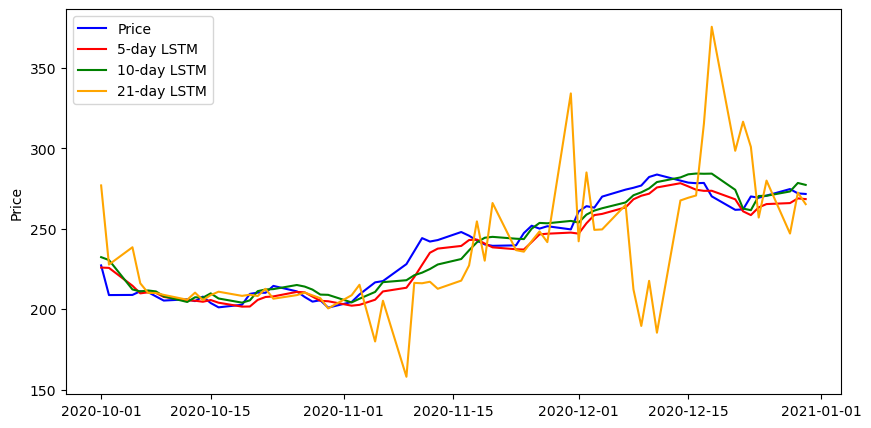

In [47]:
y_true=np.array(russia_test)
y_pred_5 = best_model_5.predict(X_test_5)
y_pred_10 = best_model_10.predict(X_test_10)
y_pred_21 = best_model_21.predict(X_test_21)

y_true_5, y_pred_5 = np.array(y_test_5), np.array(y_pred_5)
y_true_10, y_pred_10 = np.array(y_test_10), np.array(y_pred_10)
y_true_21, y_pred_21 = np.array(y_test_21), np.array(y_pred_21)

print('MAPE 5-day LSTM:',mean_absolute_percentage_error(y_true_5, y_pred_5))
print('MAPE 10-day LSTM:',mean_absolute_percentage_error(y_true_10, y_pred_10))
print('MAPE 21-day LSTM:',mean_absolute_percentage_error(y_true_21, y_pred_21))

# Visualising the results
plt.figure(figsize=(10,5))
plt.plot(russia_test.index, y_true, color = 'blue', label = 'Price')
plt.plot(russia_test.index, y_pred_5, color = 'red', label = '5-day LSTM')
plt.plot(russia_test.index, y_pred_10, color = 'green', label = '10-day LSTM')
plt.plot(russia_test.index, y_pred_21, color = 'orange', label = '21-day LSTM')
plt.xlabel("")
plt.ylabel('Price')
plt.legend()
plt.show()

We see that 5-day LSTM well catches up with the price pattern, so we'll use 5-day window to predict the prices in 2021, but first, we'll have to train the model on the whole dataset in 2020.

### Official LSTM model

In [48]:
lstm_train=pd.concat([russia_train, russia_test]) # dataset in 2020 for training
lstm_predict = pd.concat([lstm_train.tail(),russia_predict]) # dataset in 2021 plus 5 last days in 2020
lstm_predict.head(10)

,Price
Date,
2020-12-24,269.32
2020-12-25,270.64
2020-12-28,274.70
2020-12-29,272.00
2020-12-30,271.65
2021-01-04,272.00
2021-01-05,275.20
2021-01-06,272.93
2021-01-08,283.64


In [49]:
X_train_5=[]
y_train_5=[]
X_predict_5=[]
y_predict_5=[]

for i in range(5, lstm_train.shape[0]):
    X_train_5.append(lstm_train[i-5: i])
    y_train_5.append(lstm_train.iloc[i,0])

for i in range(5, lstm_predict.shape[0]):
    X_predict_5.append(lstm_predict[i-5: i])
    y_predict_5.append(lstm_predict.iloc[i,0])

X_train_5, y_train_5 = np.array(X_train_5), np.array(y_train_5)
X_predict_5, y_predict_5 = np.array(X_predict_5), np.array(y_predict_5)
print('Train shape: ', X_train_5.shape, y_train_5.shape)
print('Predict shape: ', X_predict_5.shape, y_predict_5.shape)

Train shape:  (245, 5, 1) (245,)
Predict shape:  (61, 5, 1) (61,)


In [50]:
# Early stopping to avoid overfitting of model
early_stopping = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=10)

model_checkpoint_5 = ModelCheckpoint('best_lstm_p5_5days.h5', 
                                   monitor='mean_absolute_percentage_error', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True)

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM cells 
    model.add(LSTM(units=hp.Int('units',min_value=32,max_value=512,step=16), 
                   activation='relu',
                   input_shape=(X_train_5.shape[1], 1)))

    # Tune whether to use dropout        
    if hp.Boolean("dropout"):
        model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    # Tune the number of dense units      
    model.add(Dense(units=hp.Int('units',min_value=32, max_value=512, step=16), activation='relu'))
    model.add(Dense(1))
    model.compile(
      # Tune learning rate          
      optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', 
                                                         min_value=1e-4, max_value=1e-2,sampling='log')),
      loss='mean_absolute_percentage_error',
      metrics=['mean_absolute_percentage_error'])

    return model

build_model(keras_tuner.HyperParameters())

In [51]:
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective('mean_absolute_percentage_error', direction="min"),
    max_trials=5,
    executions_per_trial=1,
    seed=456,
    project_name='lstm_bayesian_p5',
    overwrite=True)


with tf.device('/device:GPU:0'):
    tuner.search(X_train_5, y_train_5,
                 epochs=100,
                 validation_split=0.2,verbose=1,
                 callbacks=[early_stopping, model_checkpoint_5])

# Get the top model
best_model_5=tuner.get_best_models(num_models=1)[0]

#summary of best model
best_model_5.summary()

Trial 5 Complete [00h 00m 21s]
mean_absolute_percentage_error: 2.1109626293182373

Best mean_absolute_percentage_error So Far: 1.6336747407913208
Total elapsed time: 00h 01m 44s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144)               84096     
                                                                 
 dropout (Dropout)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 144)               20880     
                                                                 
 dense_1 (Dense)             (None, 1)                 145       
                                                                 
Total params: 105121 (410.63 KB)
Trainable params: 105121 (410.63 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [52]:
# predict the prices in 2021
y_pred= best_model_5.predict(X_predict_5)
lstm_pred=pd.DataFrame({'Price':y_predict_5,'LSTM Prediction':y_pred.flatten()}, index=russia_predict.index)
lstm_pred.head()

2/2 [==============================] - 0s 100ms/step


,Price,LSTM Prediction
Date,,
2021-01-04,272.00,271.596252
2021-01-05,275.20,272.110931
2021-01-06,272.93,275.121185
2021-01-08,283.64,273.056854
2021-01-11,289.49,282.360168


MAPE 5-day LSTM: 0.012456266070769818


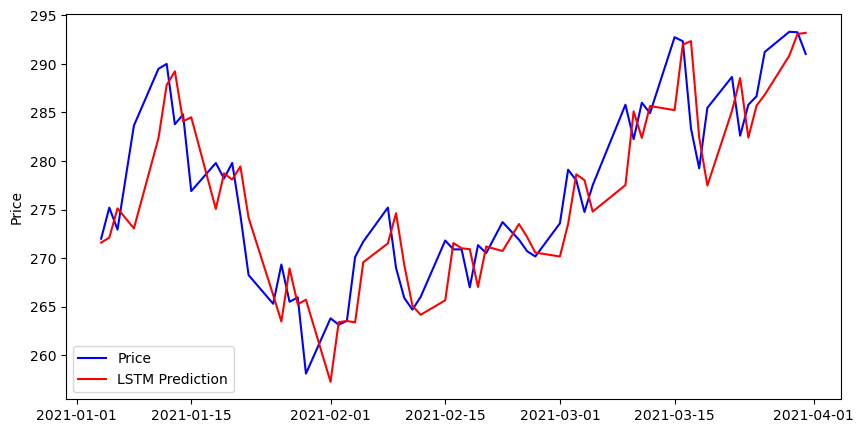

In [53]:
print('MAPE 5-day LSTM:',mean_absolute_percentage_error(lstm_pred['Price'], lstm_pred['LSTM Prediction']))

# Visualising the results
plt.figure(figsize=(10,5))
plt.plot(lstm_pred['Price'], color = 'blue', label = 'Price')
plt.plot(lstm_pred['LSTM Prediction'], color = 'red', label = 'LSTM Prediction')
plt.xlabel("")
plt.ylabel('Price')
plt.legend()
plt.show()

LSTM shows excellent performance with only **0.013** of MAPE, or the average difference between the predicted price and the actual value is **1.3%**. Now let's create the buying/selling strategy with Bollinger Band.

In [54]:
# First, we'll concatenate the last 20 values of train set to the predict set
last21days_2020 = lstm_train.tail(20)
lstm_bb = pd.concat([last21days_2020,lstm_pred[['LSTM Prediction']]])
lstm_bb.head(30)

,Price,LSTM Prediction
Date,,
2020-12-03,263.14,NaN
2020-12-04,270.00,NaN
2020-12-07,274.36,NaN
2020-12-08,275.49,NaN
2020-12-09,276.89,NaN
2020-12-10,282.20,NaN
2020-12-11,283.73,NaN
2020-12-14,279.95,NaN
2020-12-15,278.70,NaN


In [55]:
# condense the predicted price from column LSTM Prediction to column Price
lstm_bb['Price'][20:]=lstm_bb['LSTM Prediction'][20:] 
lstm_bb=lstm_bb[['Price']]
lstm_bb.head(30)

,Price
Date,
2020-12-03,263.140000
2020-12-04,270.000000
2020-12-07,274.360000
2020-12-08,275.490000
2020-12-09,276.890000
2020-12-10,282.200000
2020-12-11,283.730000
2020-12-14,279.950000
2020-12-15,278.700000


In [56]:
# We'll build the strategy logic as Buy when the Price touches the lower band (BBL_ length_standard-deviation),
#    => indicate an oversold scenario 
# and Sell when the Price touches the upper band (BBU_ length_standard-deviation) 
#    => indicate an overbought scenario

import pandas_ta as ta

def bb_strategy(data):
    bbBuy = []
    bbSell = []
    position = False
    bb = ta.bbands(data['Price'], length=20,std=2)
    data = pd.concat([data, bb], axis=1).reindex(data.index)

    for i in range(len(data)):
        if data['Price'][i] < data['BBL_20_2.0'][i]: 
            if position == False :
                bbBuy.append(data['Price'][i]) # buy when the predicted price crosses the lower band 
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif data['Price'][i] > data['BBU_20_2.0'][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(data['Price'][i]) # sell when the predicted price crosses the upper band 
                position = False
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    data['bb_Buy_Signal_price'] = bbBuy
    data['bb_Sell_Signal_price'] = bbSell

    return data


In [57]:
lstm_strategy = bb_strategy(lstm_bb)[20:] # get the prices in 2021 only
lstm_strategy.head()

,Price,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,bb_Buy_Signal_price,bb_Sell_Signal_price
Date,,,,,,,,
2021-01-04,271.596252,262.177870,273.608313,285.038756,8.355333,0.411987,NaN,NaN
2021-01-05,272.110931,262.380064,273.713859,285.047654,8.281492,0.429285,NaN,NaN
2021-01-06,275.121185,262.404596,273.751918,285.099241,8.290223,0.560334,NaN,NaN
2021-01-08,273.056854,262.307940,273.630261,284.952583,8.275636,0.474678,NaN,NaN
2021-01-11,282.360168,262.028888,273.903770,285.778651,8.670842,0.856062,NaN,NaN


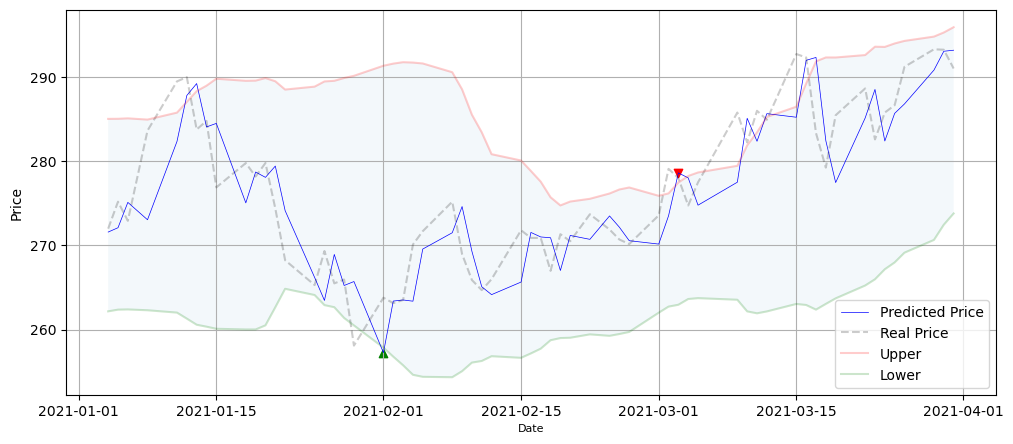

In [58]:
#plot
plt.figure(figsize=(12,5))
plt.plot(lstm_strategy['Price'],label='Predicted Price', linewidth=0.5, color='blue')
plt.plot(lstm_pred.index,lstm_pred['Price'], color = 'black', label = 'Real Price', linestyle='dashed', alpha=0.2)
plt.scatter(lstm_strategy.index, lstm_strategy['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
plt.scatter(lstm_strategy.index, lstm_strategy['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)
plt.plot(lstm_strategy['BBU_20_2.0'], label='Upper', color='red', alpha=0.2) #Upper band
plt.plot(lstm_strategy['BBL_20_2.0'], label='Lower', color='green', alpha=0.2) #lower band
plt.fill_between(lstm_strategy.index, lstm_strategy['BBL_20_2.0'], lstm_strategy['BBU_20_2.0'], alpha=0.05)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()

In [59]:
# date to buy
buying_date=lstm_strategy[~lstm_strategy['bb_Buy_Signal_price'].isna()]
buying_date

,Price,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,bb_Buy_Signal_price,bb_Sell_Signal_price
Date,,,,,,,,
2021-02-01,257.268829,257.871147,274.609039,291.346932,12.190343,-0.017993,257.268829,NaN


In [60]:
# date to sell
selling_date=lstm_strategy[~lstm_strategy['bb_Sell_Signal_price'].isna()]
selling_date

,Price,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,bb_Buy_Signal_price,bb_Sell_Signal_price
Date,,,,,,,,
2021-03-03,278.623016,262.960252,270.216862,277.473473,5.370953,1.079207,NaN,278.623016


In [61]:
# the number of days that we should hold the stock
(selling_date.index[0]-buying_date.index[0]).days

30

It's predicted that we should buy on Feb 1st and sell on Mar 3rd, gaining a return of **>$20**/stock after holding for 30 days.

# Conclusion <a class="anchor" id="con"></a>

Overall, LSTM model, with only 1.3% of MAPE, has outperformed other traditional ones such as ARIMA and PROPHET. As a room for improvement, it is suggested to input a bigger dataset in order to further minimize the error.